In [1]:
using LinearAlgebra
using SparseArrays

In [73]:
#wyliczanie indeksu = i + (j-1)*NX + (k-1)*NX*NY
NX = 4
NY = 3
NZ = 2
Δx = 0.05
Δy = 0.05
Δz = 0.05
idx2 = 1/Δx
idy2 = 1/Δy
idz2 = 1/Δz

d = zeros(NX,NY,NZ)

function build_matrix(ϕ)
    A = spzeros(length(ϕ), length(ϕ))
    nx, ny, nz = size(ϕ)
    for k = 1:size(ϕ)[3], j = 1:size(ϕ)[2], i = 1:size(ϕ)[1]
        u = i + (j-1)*nx + (k-1)*nx*ny
        #println(i, " ", j, " ", k)
        #println(u)
        
        A[u,u] = -2.0*(idx2 + idy2 + idz2)
        if i == 1                  # i-1
            A[u,u+nx-1] = idx2
        else
            A[u,u-1] = idx2
        end
        if i == nx                 # i+1
            A[u,u-nx+1] = idx2      
        else
            A[u,u+1] = idx2
        end
        if j == 1                  # j-1
            A[u,u+(ny-1)*nx] = idy2   
        else
            A[u,u-nx] = idy2
        end
        if j == ny                  # j+1
            A[u,u-(ny-1)*nx] = idy2 
        else
            A[u,u+nx] = idy2
        end
        if k == 1                  # k-1
            A[u,u+(nz-1)*nx*ny] = idz2   
        else
            A[u,u-nx*ny] = idz2
        end
        if k == nz                  # k+1
            A[u,u-(nz-1)*nx*ny] = idz2
        else
            A[u,u+nx*ny] = idz2
        end
    end
    return A
end

build_matrix (generic function with 1 method)

In [17]:
function preconditioner_jacobi(A)
    return Diagonal([1/A[i, i] for i in 1:size(A)[1]])
end

preconditioner_jacobi (generic function with 1 method)

In [44]:
norm(x) = sqrt(sum(x.^2))

function PCG(A, b, x, tol)
    conv = false
    M = preconditioner_jacobi(A)
    g = A*x - b
    s = M*g
    d = -s

    L2 = norm(g)
    while L2 > tol
        z = A*d
        α = dot(g,s)
        β = dot(d,z)
        x = x + (α/β)*d
        g = g + (α/β)*z
        s = M*g
        β = α
        α = dot(g,s)
        d = (α/β)*d - s
        
        L2 = norm(g)
        if L2 < tol
            conv = true
            break
        end
    end

    if conv == false
        println("PCG failed to converge, L2 = $(L2)")
    end
    return x
end

PCG (generic function with 1 method)

In [24]:
include("pic3d.jl")
using .PIC3D
using PyPlot
using LinearAlgebra
using PyCall
anim =  pyimport("matplotlib.animation");
using BenchmarkTools

In [25]:
function generate_particles!(NP, d)
    num = d / (2*NP / (PIC3D.XL*PIC3D.YL*PIC3D.ZL))
    println(num)
    electrons = PIC3D.Species(q=PIC3D.q_e*num, m=PIC3D.m_e*num)
    ions = PIC3D.Species(q=-PIC3D.q_e*num, m=PIC3D.m_e*num*2000)
    @inbounds for i = 1:NP
        x = [rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL]
        v = [5e5, 0, 0]
        push!(electrons.x, [x...])
        push!(electrons.v, [v...])
        push!(ions.x, [x...])
        push!(ions.v, [v...])
        
        x = [rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL]
        v = [-5e5, 0, 0]
        push!(electrons.x, [x...])
        push!(electrons.v, [v...])
        push!(ions.x, [x...])
        push!(ions.v, [v...])
    end

    return electrons, ions
end

generate_particles! (generic function with 1 method)

In [26]:
function compute_EK_particles(electrons, ions)
    ek = 0
    @inbounds for i in eachindex(electrons.v)
        ek += electrons.m*dot(electrons.v[i], electrons.v[i])
    end
    # @inbounds for i in eachindex(ions.v)
    #     ek += ions.m*dot(ions.v[i], ions.v[i])
    # end
    ek = 0.5*ek
    return ek
end

function compute_EK_particles2(electrons, ions, NP, d)
    ek = 0
    @inbounds for i in eachindex(electrons.v)
        ek += electrons.m*dot(electrons.v[i], electrons.v[i])
    end
    @inbounds for i in eachindex(ions.v)
        ek += electrons.m*dot(ions.v[i], ions.v[i])
    end
    ek = 0.5*ek*(d / (2*NP / (PIC3D.Δx*PIC3D.Δy*PIC3D.Δz)))
    return ek
end

function compute_EP_field()
    ep = 0
    @inbounds for k = 1:(PIC3D.NZ-1), j = 1:(PIC3D.NY-1), i = 1:(PIC3D.NX-1)
        ep += PIC3D.Ex[i,j,k]^2 + PIC3D.Ey[i,j,k]^2 + PIC3D.Ez[i,j,k]^2
    end
    ep = 0.5 * PIC3D.ε_0 * ep * PIC3D.Δx*PIC3D.Δy*PIC3D.Δz
    return ep
end


function compute_EP_potential()
    ep = 0
    @inbounds for k = 1:(PIC3D.NZ-1), j = 1:(PIC3D.NY-1), i = 1:(PIC3D.NX-1)
        ep += PIC3D.ρ[i,j,k] * PIC3D.ϕ[i,j,k]
    end
    ep = 0.5* PIC3D.ε_0 *ep
    return ep
end

compute_EP_potential (generic function with 1 method)

1.0986328125e6
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


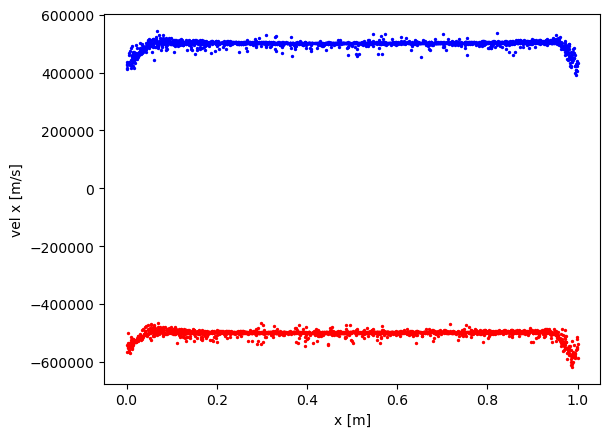

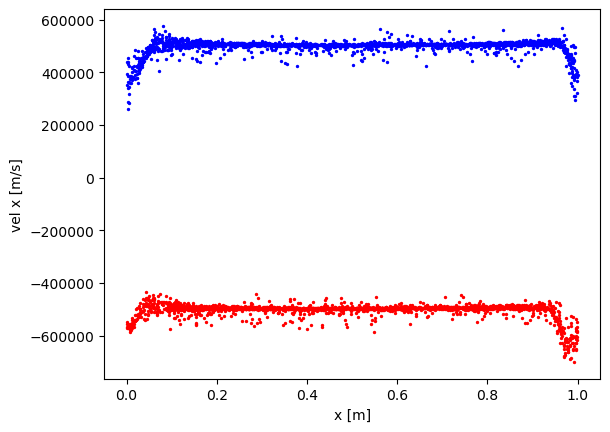

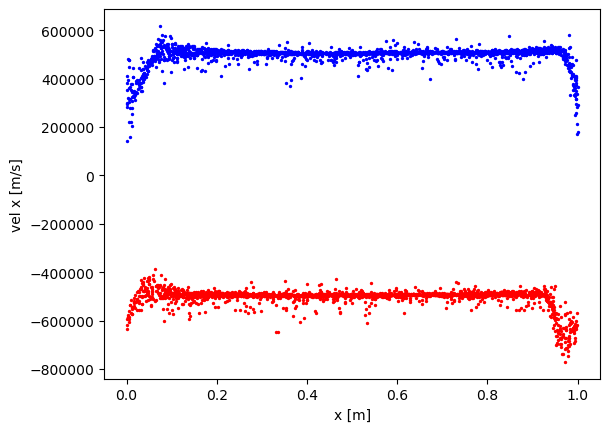

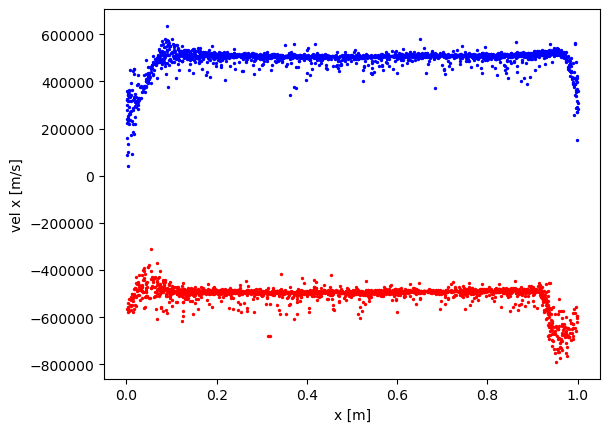

In [18]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

timesteps = 100

historyxx = []
historyvel = []
EK = []
EK2 = []
EE = []
EP = []

for i = 1:timesteps
    println(i)
    PIC3D.timestep_PCG!(electrons, ions)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[ex...] for ex in electrons.x])
        push!(historyvel, [[ev...] for ev in electrons.v])
    end
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EK2, compute_EK_particles2(electrons, ions, NP, d))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

In [23]:
using SparseArrays
using LinearAlgebra

function build_coefficient_matrix(nx, ny, nz, Δx, Δy, Δz)
    N = nx * ny * nz
    A = spzeros(N, N)
    idx2 = 1/Δx^2
    idy2 = 1/Δy^2
    idz2 = 1/Δz^2

    for k in 1:nz, j in 1:ny, i in 1:nx
        u = i + (j-1)*nx + (k-1)*nx*ny

        A[u, u] = -2.0 * (idx2 + idy2 + idz2)
        if i > 1
            A[u, u-1] = idx2
        end
        if i < nx
            A[u, u+1] = idx2
        end
        if j > 1
            A[u, u-nx] = idy2
        end
        if j < ny
            A[u, u+nx] = idy2
        end
        if k > 1
            A[u, u-nx*ny] = idz2
        end
        if k < nz
            A[u, u+nx*ny] = idz2
        end
    end
    return A
end
function build_coefficient_matrix_pbc(nx, ny, nz, Δx, Δy, Δz)
    N = nx * ny * nz
    A = spzeros(N, N)
    idx2 = 1 / Δx^2
    idy2 = 1 / Δy^2
    idz2 = 1 / Δz^2

    for k in 1:nz, j in 1:ny, i in 1:nx
        u = i + (j - 1) * nx + (k - 1) * nx * ny

        A[u, u] = -2.0 * (idx2 + idy2 + idz2)

        # Warunki brzegowe periodyczne w kierunku x
        if i == 1
            A[u, u + nx - 1] = idx2
        else
            A[u, u - 1] = idx2
        end

        if i == nx
            A[u, u - nx + 1] = idx2
        else
            A[u, u + 1] = idx2
        end

        # Warunki brzegowe periodyczne w kierunku y
        if j == 1
            A[u, u + (ny - 1) * nx] = idy2
        else
            A[u, u - nx] = idy2
        end

        if j == ny
            A[u, u - (ny - 1) * nx] = idy2
        else
            A[u, u + nx] = idy2
        end

        # Warunki brzegowe periodyczne w kierunku z
        if k == 1
            A[u, u + (nz - 1) * nx * ny] = idz2
        else
            A[u, u - nx * ny] = idz2
        end

        if k == nz
            A[u, u - (nz - 1) * nx * ny] = idz2
        else
            A[u, u + nx * ny] = idz2
        end
    end

    return A
end


function build_b_vector(ρ, ε₀)
    nx, ny, nz = size(ρ)
    b = zeros(Float64, nx * ny * nz)

    for k in 1:nz, j in 1:ny, i in 1:nx
        u = i + (j-1)*nx + (k-1)*nx*ny
        b[u] = -ρ[i,j,k] / ε₀
    end
    return b
end


function jacobi_preconditioner(A)
    return Diagonal([1/A[i,i] for i in 1:size(A, 1)])
end


function apply_solution_to_ϕ!(ϕ, x)
    nx, ny, nz = size(ϕ)
    for k in 1:nz, j in 1:ny, i in 1:nx
        u = i + (j-1)*nx + (k-1)*nx*ny
        ϕ[i,j,k] = x[u]
    end
end

normL2(x) = sqrt(sum(x.^2))

function compute_potential_PCG!(ϕ, ρ, Δx, Δy, Δz, ε₀, tolerance, max_it)
    nx, ny, nz = size(ϕ)
    A = build_coefficient_matrix_pbc(nx, ny, nz, Δx, Δy, Δz)
    b = build_b_vector(ρ, ε₀)
    M = jacobi_preconditioner(A)
    x = zeros(Float64, length(b))

    g = A * x - b
    s = M * g
    d = -s

    L2 = normL2(g)
    it = 1

    while L2 > tolerance && it < max_it
        z = A * d
        α = dot(g, s) / dot(d, z)
        x = x + α * d
        g = g + α * z
        s = M * g
        β = dot(g, s) / (α * dot(d, z))
        d = -s + β * d

        L2 = normL2(g)
        it += 1
    end
    println("L2 = $(L2)")

    if L2 > tolerance
        println("PCG failed to converge, L2 = $L2")
    end

    apply_solution_to_ϕ!(ϕ, x)
end

nx, ny, nz = 10, 10, 10
ϕ = zeros(Float64, nx, ny, nz)
ρ = rand(Float64, nx, ny, nz)
Δx, Δy, Δz = 1.0, 1.0, 1.0
ε₀ = 8.854e-12 
tolerance = 1e-6
max_it = 1000

compute_potential_PCG!(ϕ, ρ, Δx, Δy, Δz, ε₀, tolerance, max_it)

println(ϕ)


L2 = 1.1737897334586332e20
PCG failed to converge, L2 = 1.1737897334586332e20
[-1.348761601352242e29 -1.3487616013731794e29 -1.3487616013777017e29 -1.3487616013851608e29 -1.3487616013950979e29 -1.3487616013859757e29 -1.3487616013663692e29 -1.348761601343585e29 -1.3487616013454139e29 -1.3487616013488122e29; -1.3487616013597899e29 -1.3487616013496e29 -1.348761601349343e29 -1.3487616013506688e29 -1.3487616013698565e29 -1.3487616013769359e29 -1.348761601381115e29 -1.3487616013826382e29 -1.34876160137997e29 -1.3487616013704154e29; -1.3487616013656618e29 -1.348761601336794e29 -1.3487616013179854e29 -1.3487616013212193e29 -1.348761601331756e29 -1.3487616013592552e29 -1.3487616013848091e29 -1.3487616014152533e29 -1.3487616014166049e29 -1.3487616013971952e29; -1.348761601389779e29 -1.3487616013479818e29 -1.348761601315342e29 -1.3487616013072337e29 -1.348761601307188e29 -1.3487616013433859e29 -1.348761601374781e29 -1.3487616014107249e29 -1.3487616014282432e29 -1.3487616014148636e29; -1.348761601